# Post hoc calibration by Temperature and Platt scaling of the Perch v2 model on BirdSet

In [14]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")

In [16]:
from uncertainbird.utils.misc import load_data
from uncertainbird.modules.models.convnext_bs import ConvNeXtBS

log_dir = "/workspace/logs/predictions/convnext_bs"
data, predictions, targets, valid_keys = load_data(log_dir, load_logits=True)
model = ConvNeXtBS()
model_name = 'ConvNeXT_BS'

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])


/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
data["POW"].keys()
model_name = 'ConvNeXT_BS'

In [18]:
from uncertainbird.utils.misc import prune_non_target_classes

data = prune_non_target_classes(data, targets)

# Temperature scaling on POW validation set

In [19]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_temperature,
    apply_temperature_scaling,
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
temperature = fit_global_temperature(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.001
)

print(f"Optimal temperature: {temperature:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_temperature_scaling(
        data_POW[dataset_name]["logits"], temperature, model= model
    )

Optimal temperature: 1.496


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4872)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1181)
ECE Top-3: tensor(0.1177)
ECE Top-5: tensor(0.0854)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0229)
Miscalibration Score (MCS): tensor(-0.1180)
ECE Under-confidence: tensor(0.1180)
ECE Over-confidence: tensor(3.3722e-05)
Accuracy: tensor(0.9988)
cmAP: tensor(0.4872)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0024)
ECE Weighted: tensor(0.1138)
ECE Top-3: tensor(0.1138)
ECE Top-5: tensor(0.0811)
ECE Top-10: tensor(0.0443)
ECE Top-21: tensor(0.0231)
Miscalibration Score (MCS): tensor(-0.1136)
ECE Under-confidence: tensor(0.1137)
ECE Over-confidence: tensor(0.0001)
Accuracy: tensor(0.9964)
cmAP: tensor(0.6136)
Precision: tensor(0.0753)
Recall: tensor(0.0211)
F1 Score: tensor(0.0293)
AUROC: tensor(0.1135)
ECE: tensor(0.0033)
ECE We

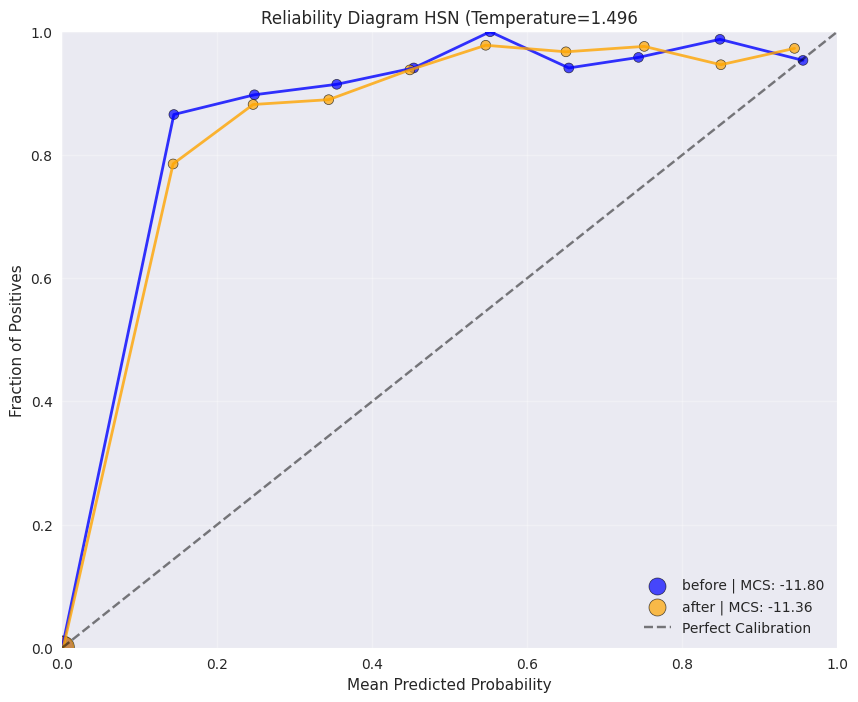

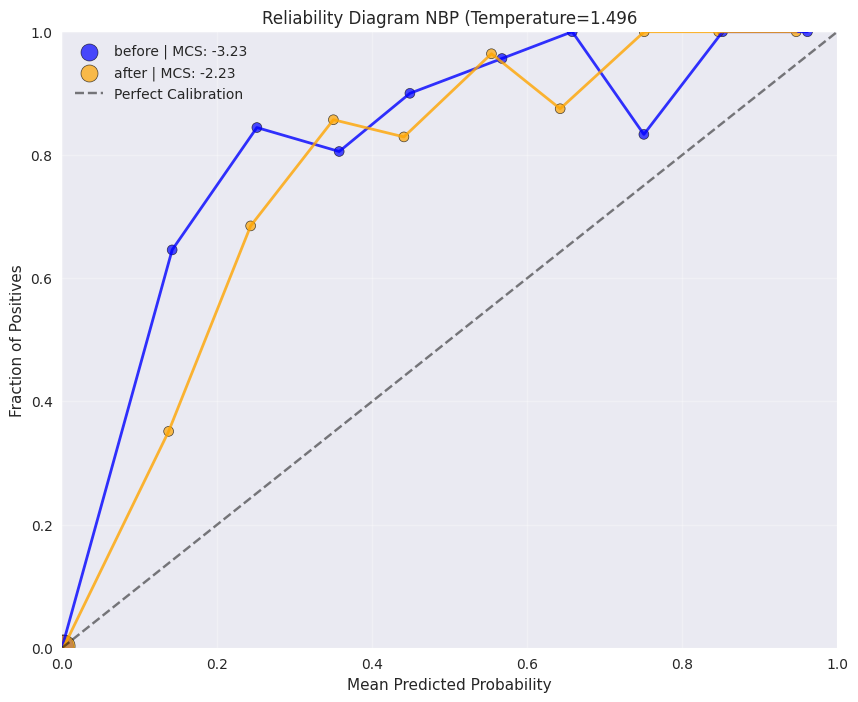

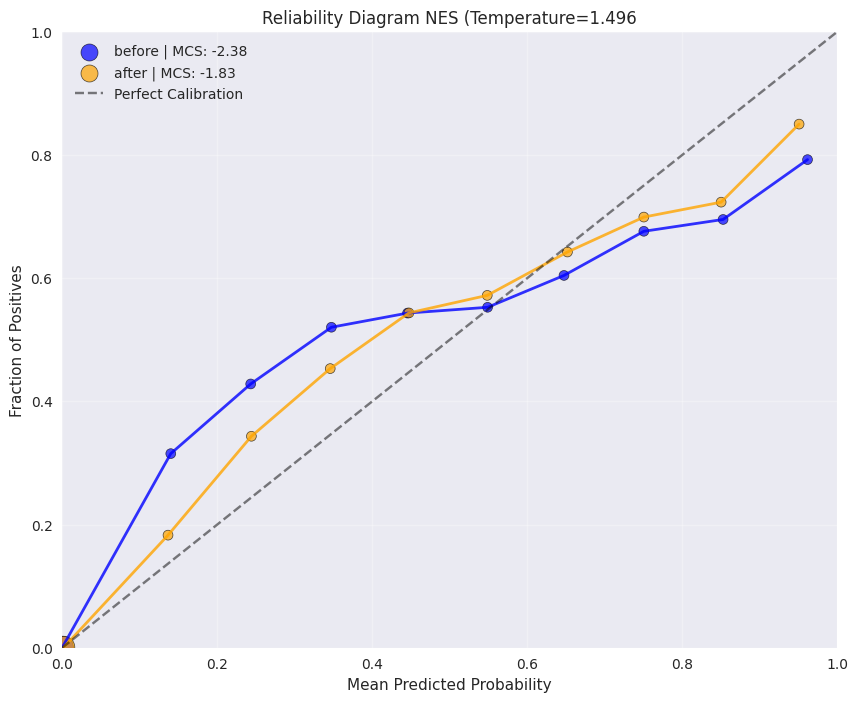

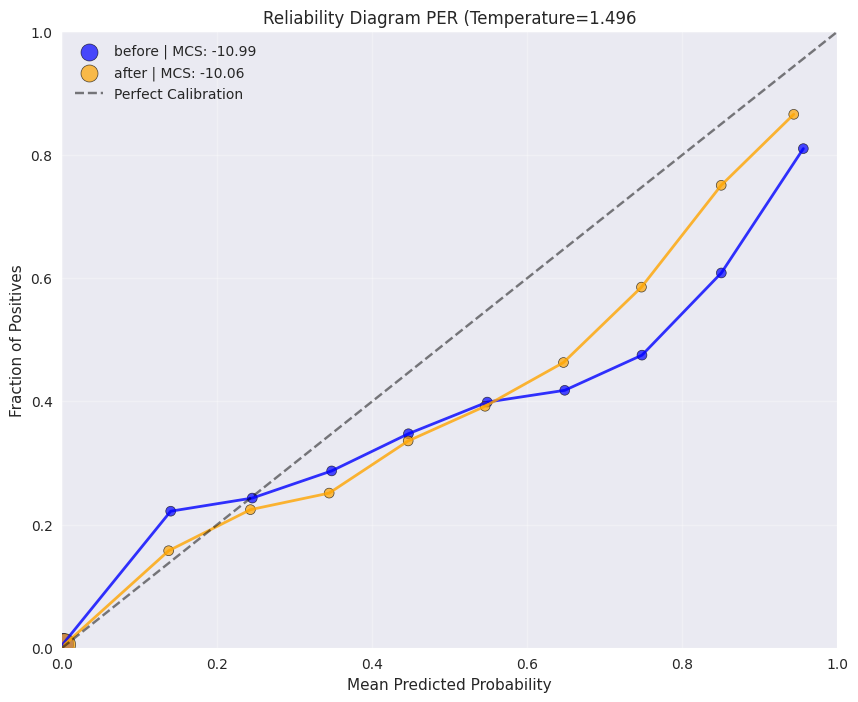

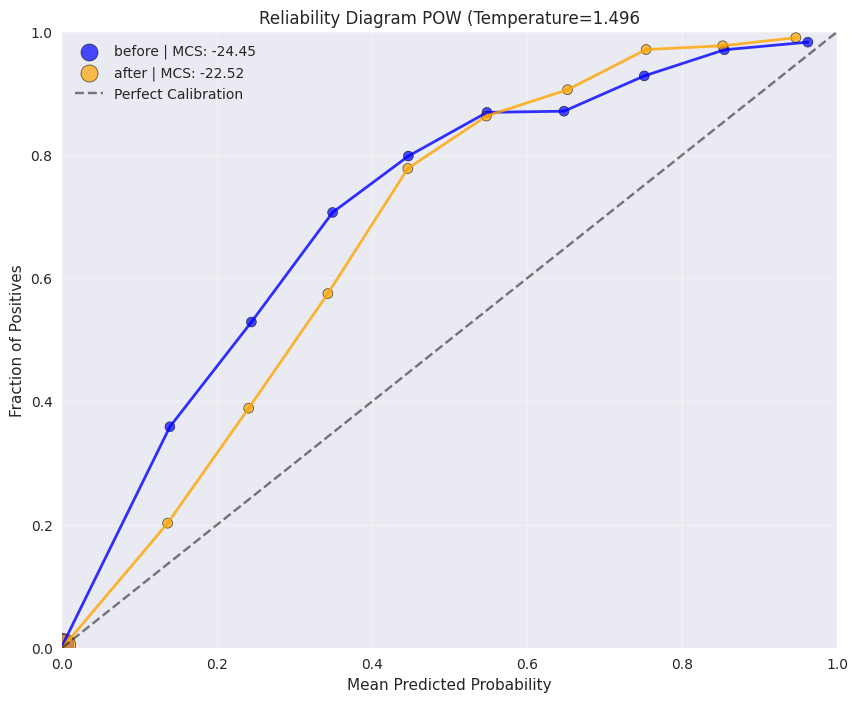

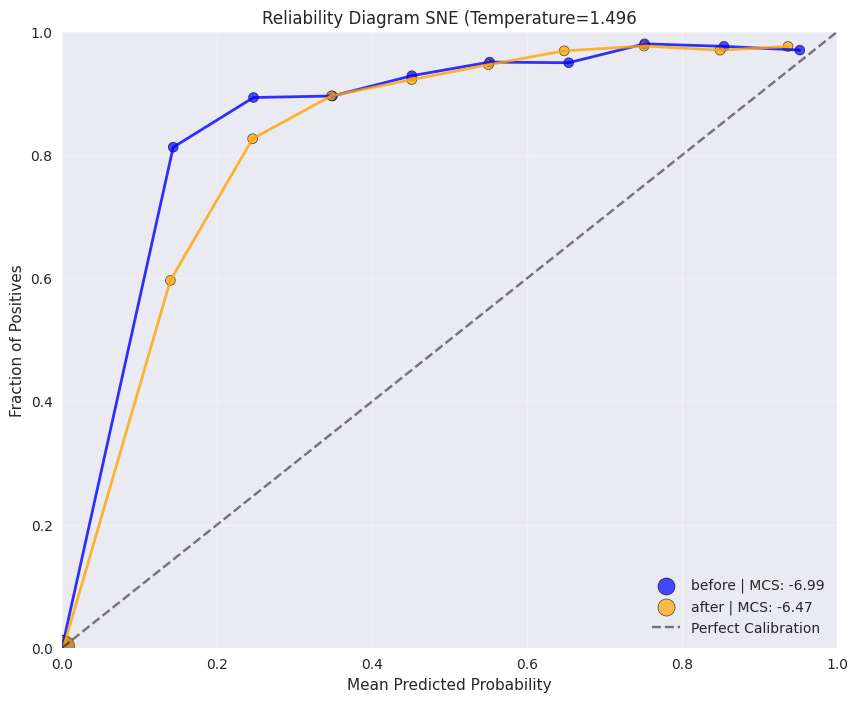

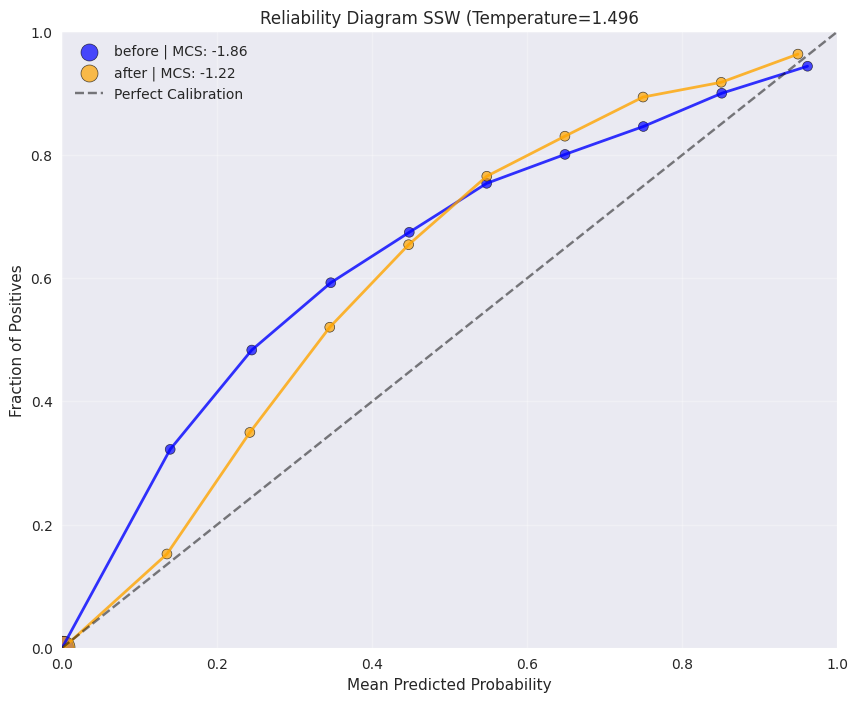

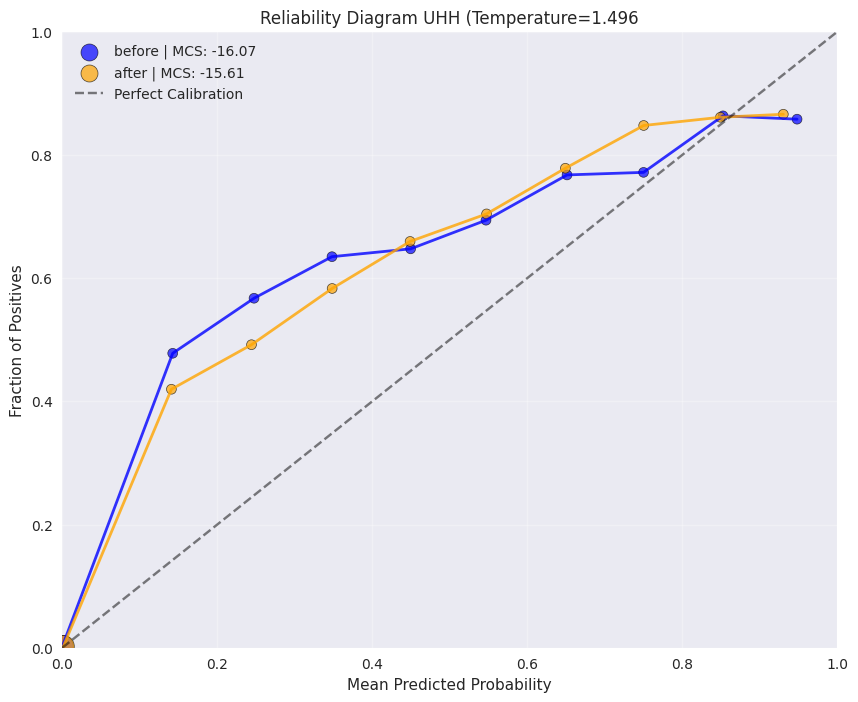

In [20]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before temperature scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Temperature={temperature:.3f}",
    )

# Platt scaling on POW validation set

In [ ]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_platt_scaling,
    apply_platt_scaling
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
slope, bias = fit_global_platt_scaling(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.01
)

print(f"Optimal slope: {slope:.3f}, bias: {bias:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_platt_scaling(
        data_POW[dataset_name]["logits"], slope, bias, model= model
    )

Optimal slope: 0.842, bias: 1.340


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4872)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1181)
ECE Top-3: tensor(0.1177)
ECE Top-5: tensor(0.0854)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0229)
Miscalibration Score (MCS): tensor(-0.1180)
ECE Under-confidence: tensor(0.1180)
ECE Over-confidence: tensor(3.3722e-05)
Accuracy: tensor(0.9989)
cmAP: tensor(0.4872)
Precision: tensor(0.0343)
Recall: tensor(0.0093)
F1 Score: tensor(0.0132)
AUROC: tensor(0.0454)
ECE: tensor(0.0019)
ECE Weighted: tensor(0.1072)
ECE Top-3: tensor(0.1083)
ECE Top-5: tensor(0.0768)
ECE Top-10: tensor(0.0419)
ECE Top-21: tensor(0.0222)
Miscalibration Score (MCS): tensor(-0.1069)
ECE Under-confidence: tensor(0.1071)
ECE Over-confidence: tensor(0.0001)
Accuracy: tensor(0.9964)
cmAP: tensor(0.6136)
Precision: tensor(0.0753)
Recall: tensor(0.0211)
F1 Score: tensor(0.0293)
AUROC: tensor(0.1135)
ECE: tensor(0.0033)
ECE We

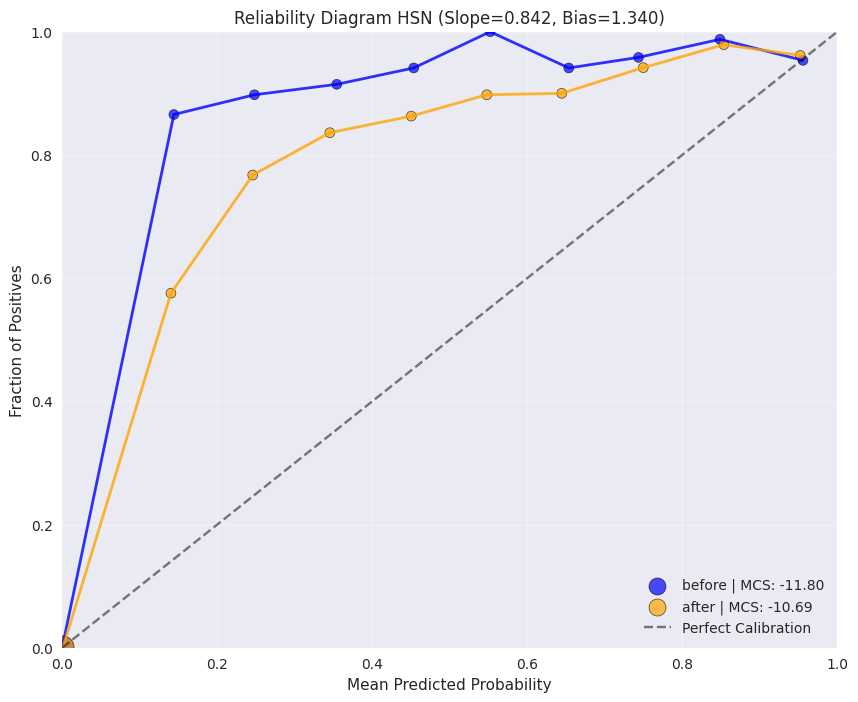

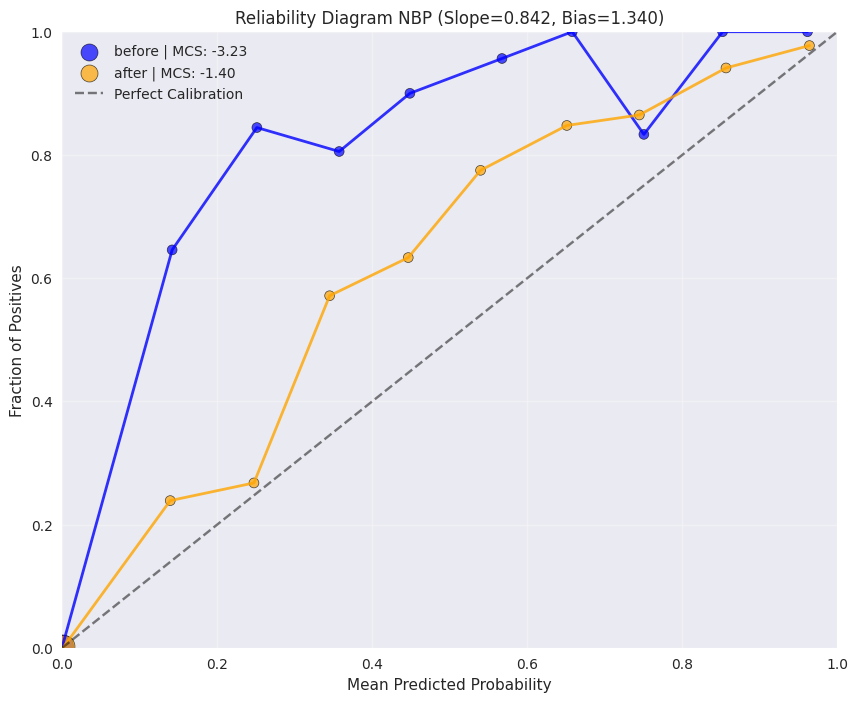

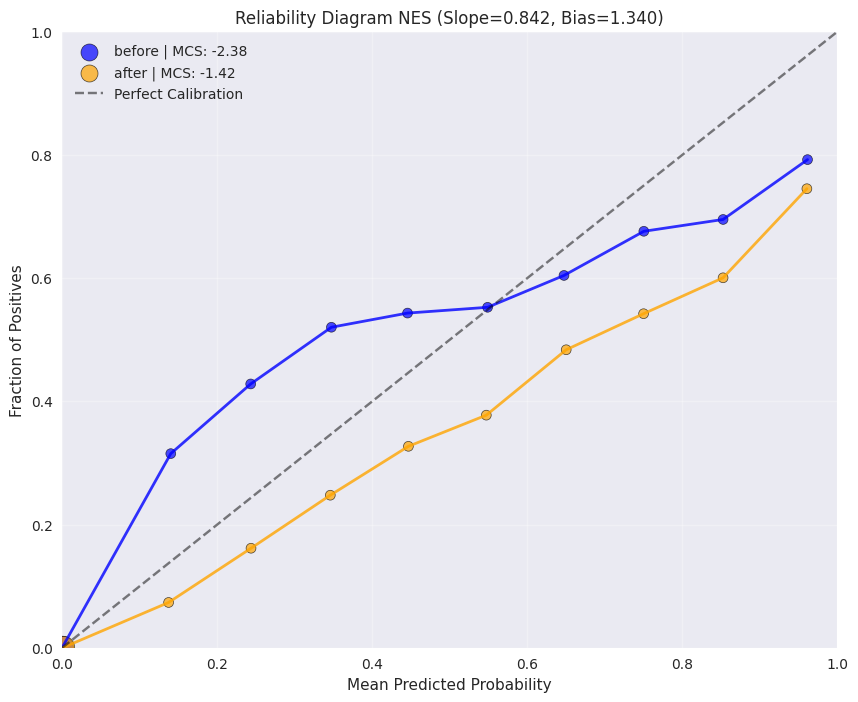

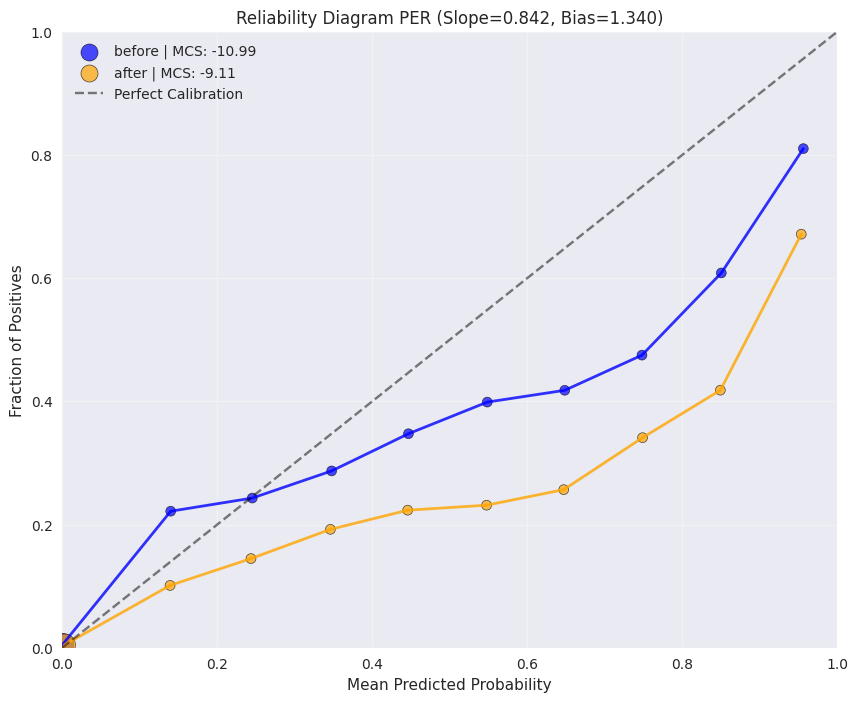

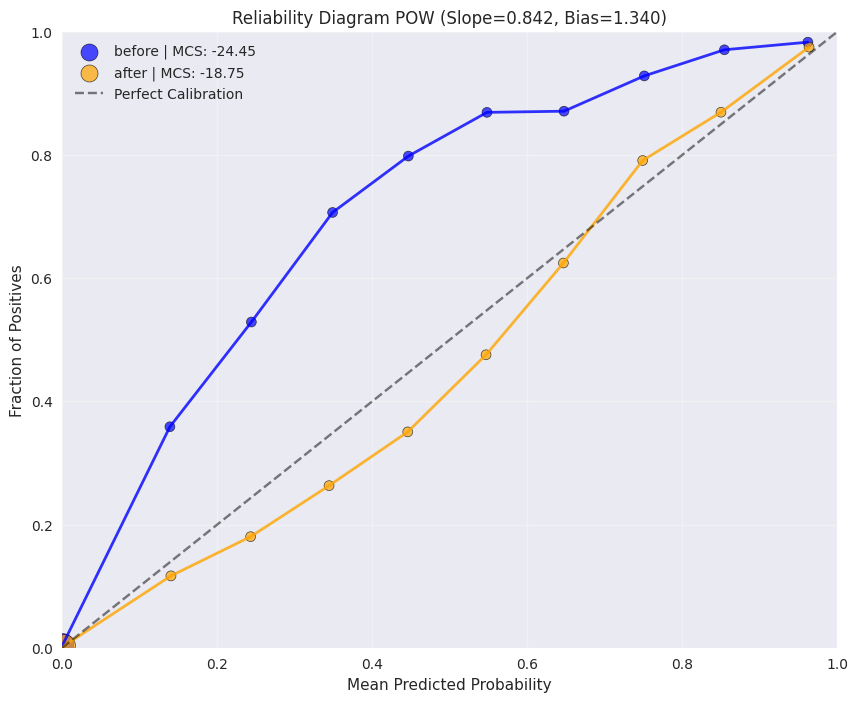

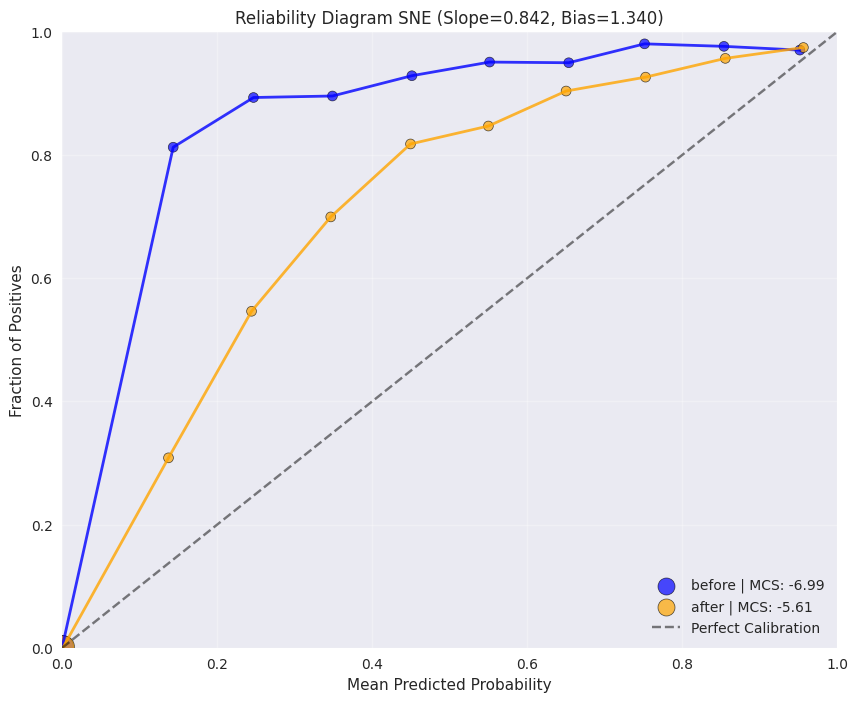

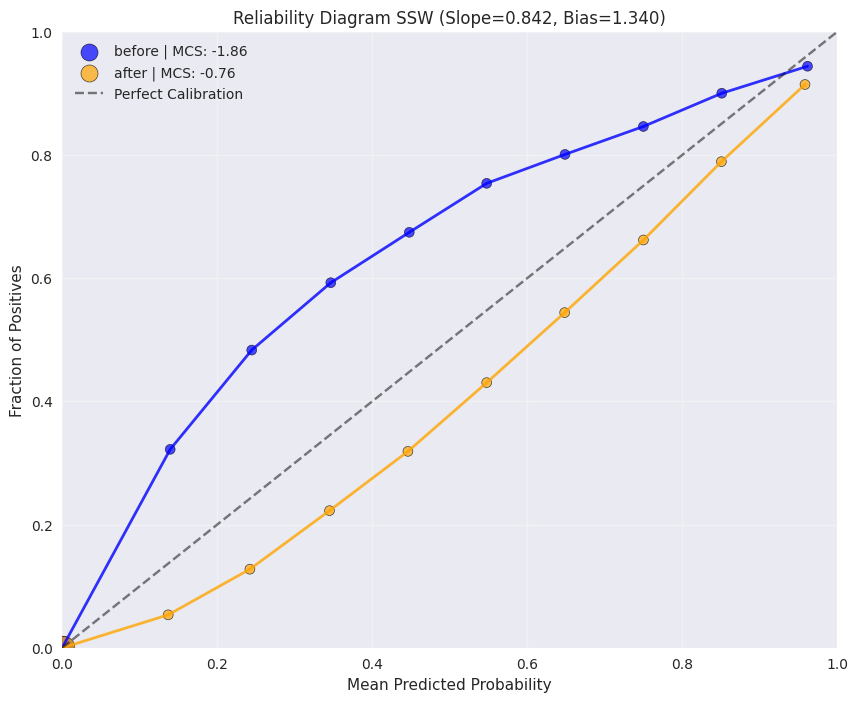

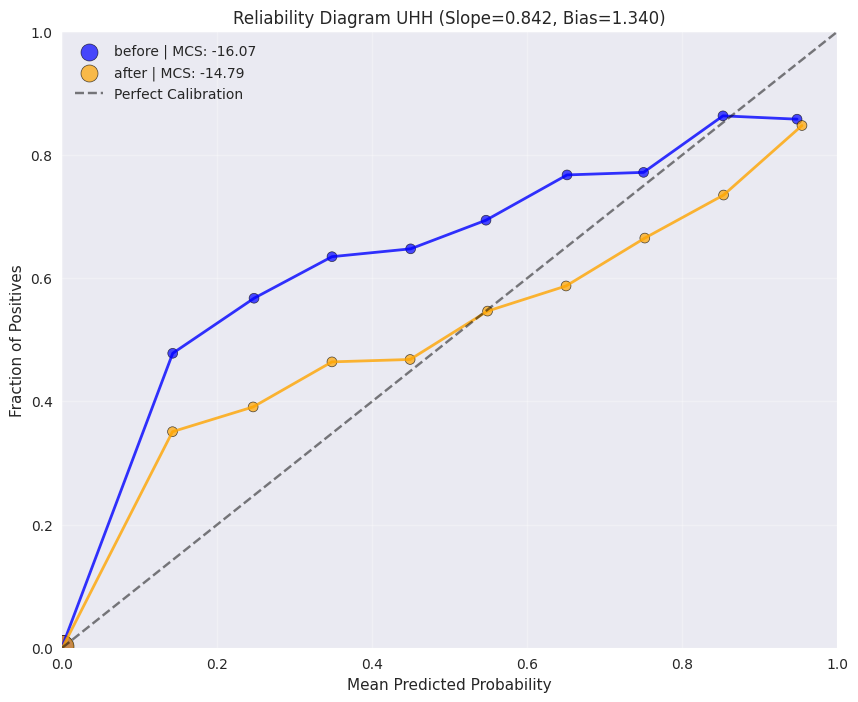

In [22]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before platt scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Slope={slope:.3f}, Bias={bias:.3f})",
    )

# Platt scaling using a porton of the test data

In [23]:
from uncertainbird.utils.misc import slit_based_on_first_n_samples

# 10min of audio per class -> 120 samples of 5s each
data_120 = slit_based_on_first_n_samples(data, n=120)

## Global parameters for all classes

### Temperature scaling

In [31]:
for ds in valid_keys:

    # compute global temperature value based on POW
    temperature = fit_global_temperature(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal temperature: {temperature:.3f} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperature, model= model
    )
    print('Before temperature scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal temperature: 1.346 for HSN
Before platt scaling:


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1182)
ECE Top-3: tensor(0.1179)
ECE Top-5: tensor(0.0856)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0230)
Miscalibration Score (MCS): tensor(-0.1182)
ECE Under-confidence: tensor(0.1182)
ECE Over-confidence: tensor(3.4392e-05)
After platt scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0017)
ECE Weighted: tensor(0.1157)
ECE Top-3: tensor(0.1156)
ECE Top-5: tensor(0.0830)
ECE Top-10: tensor(0.0453)
ECE Top-21: tensor(0.0228)
Miscalibration Score (MCS): tensor(-0.1156)
ECE Under-confidence: tensor(0.1156)
ECE Over-confidence: tensor(4.9896e-05)
Optimal temperature: 1.406 for NBP
Before platt scaling:
Accuracy: tensor(0.9965)
cmAP: tensor(0.6088)
Precision: tensor(0.0730)
Recall: tensor

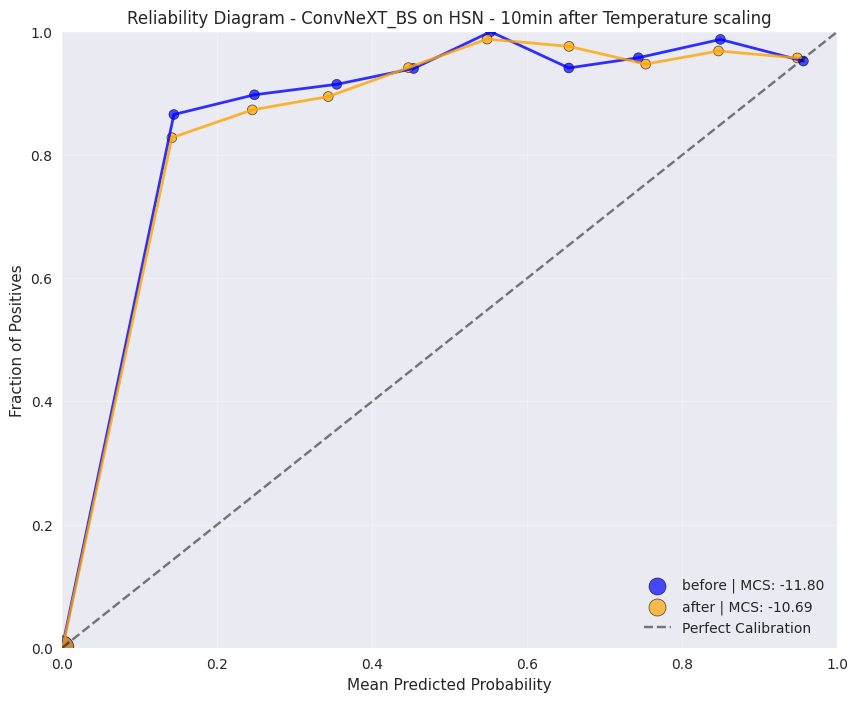

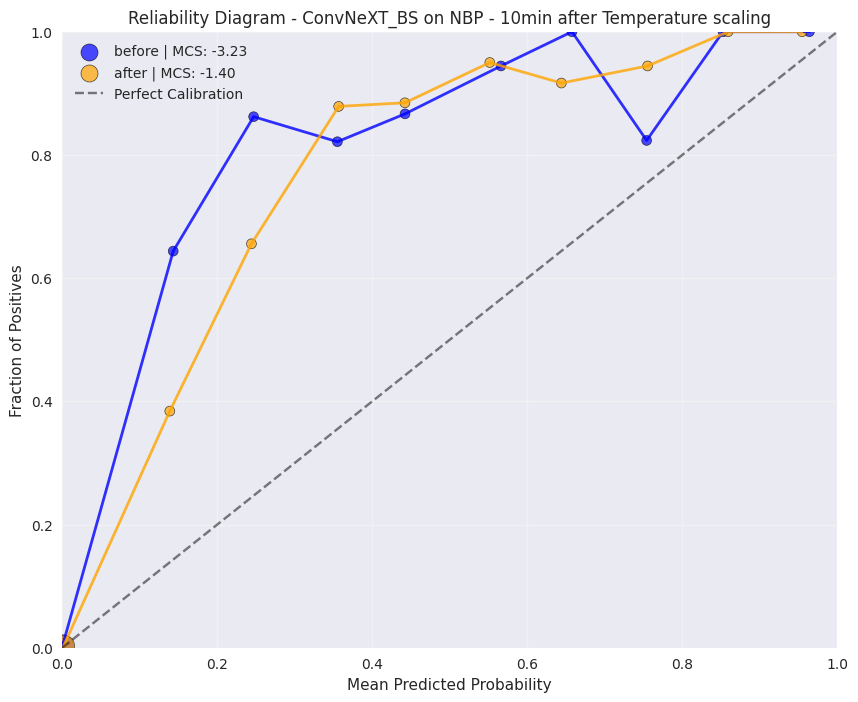

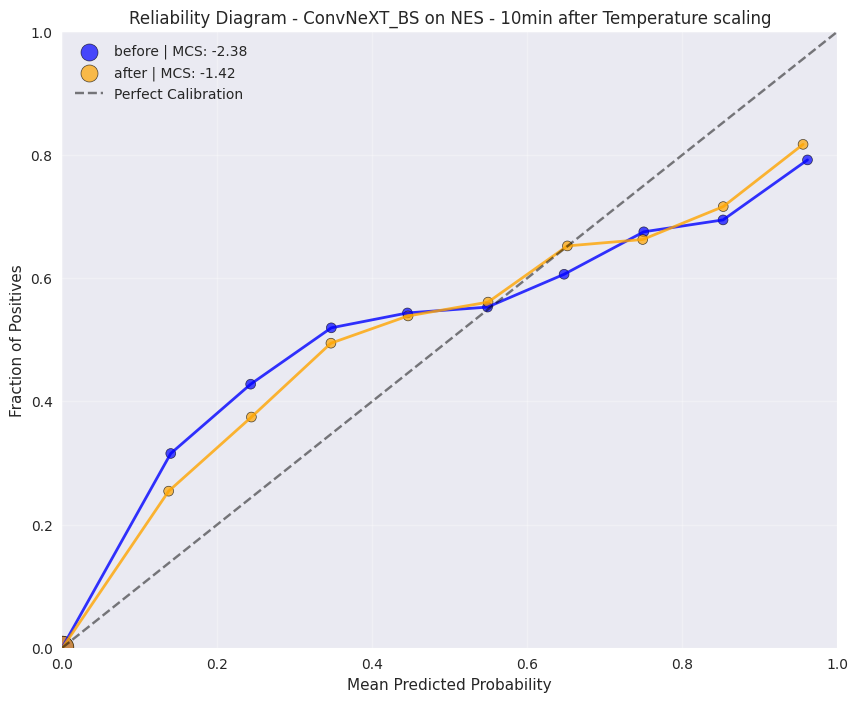

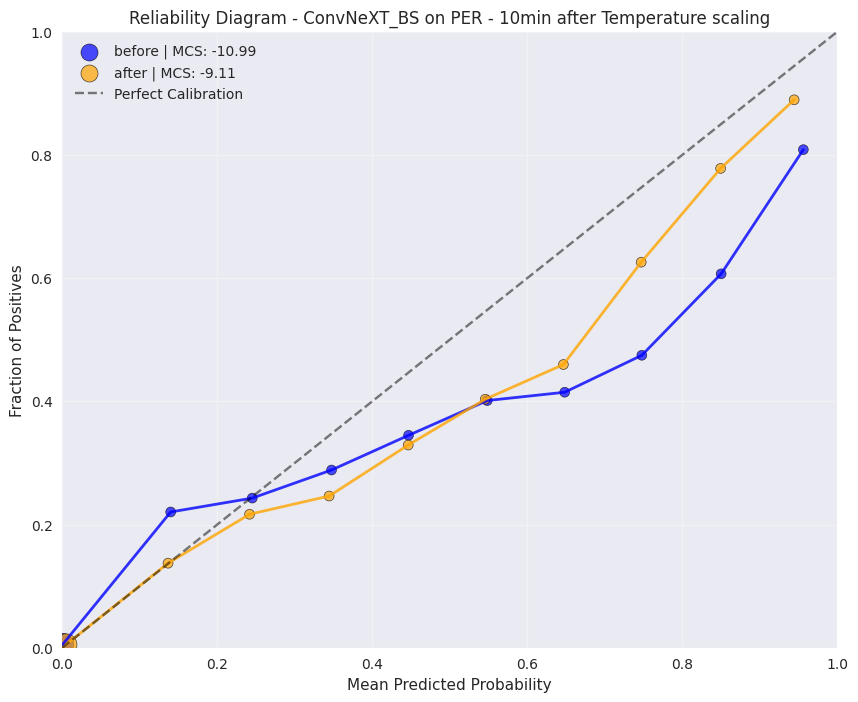

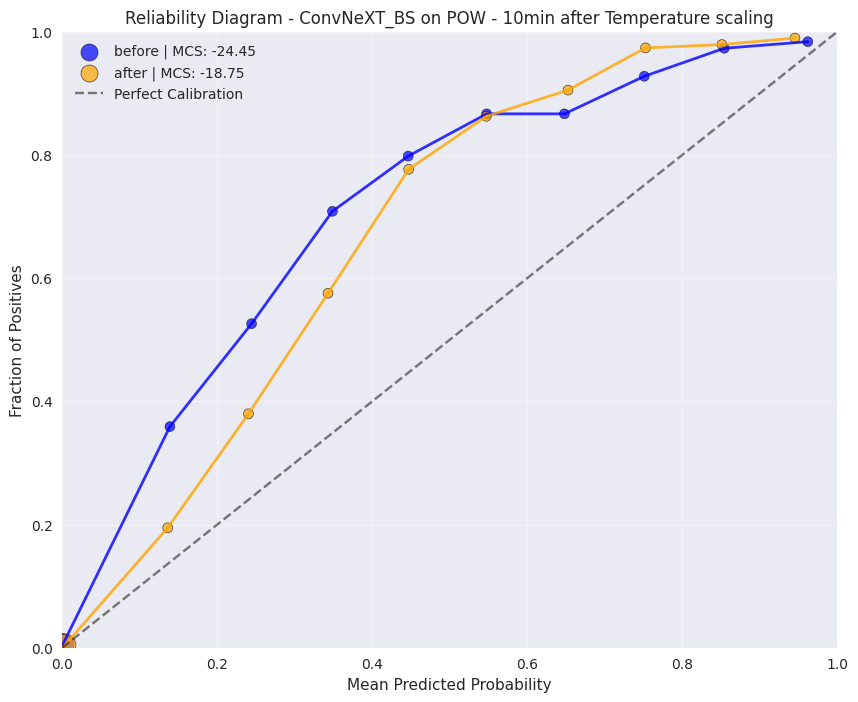

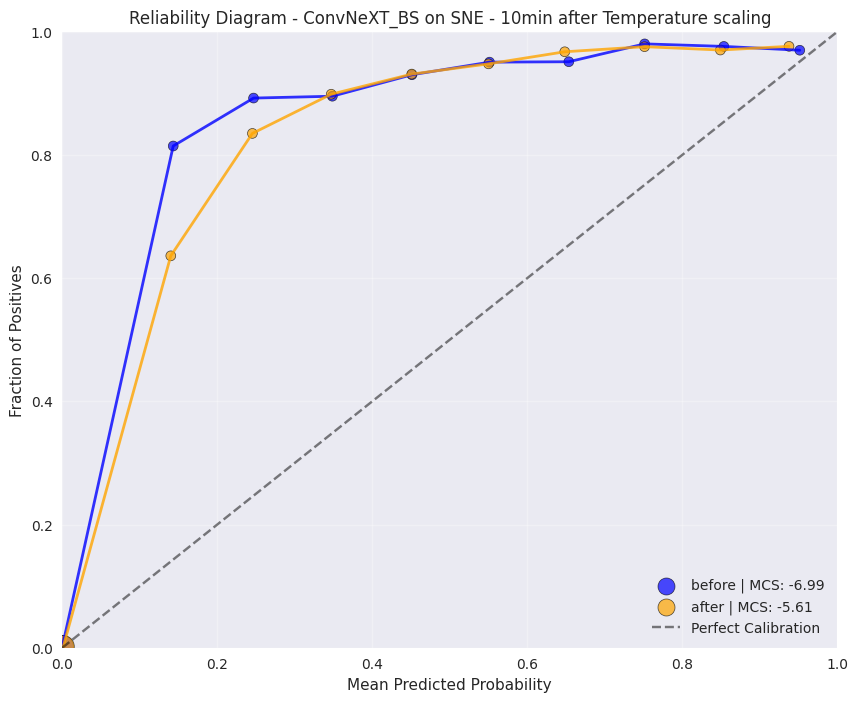

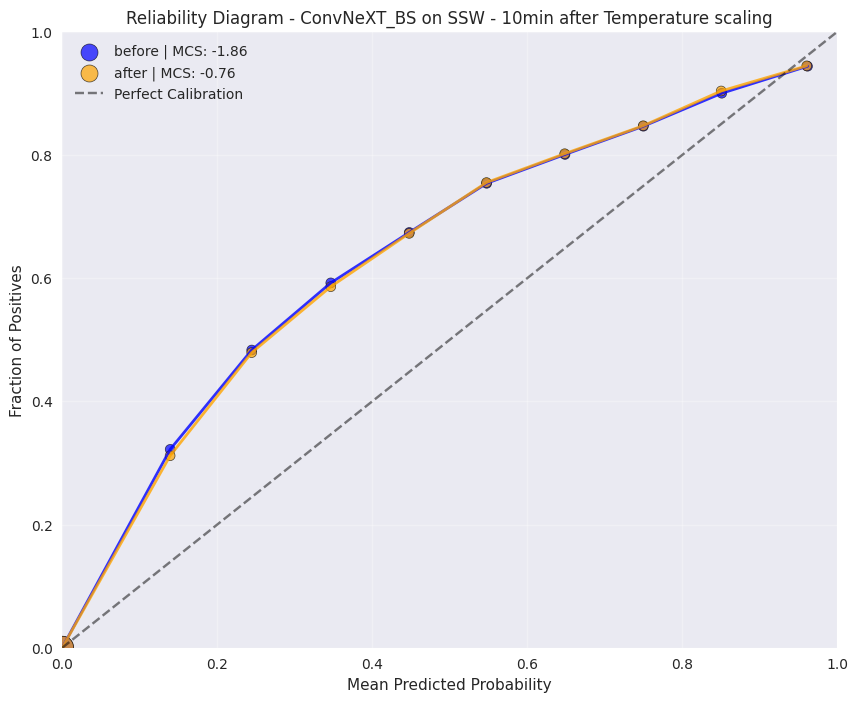

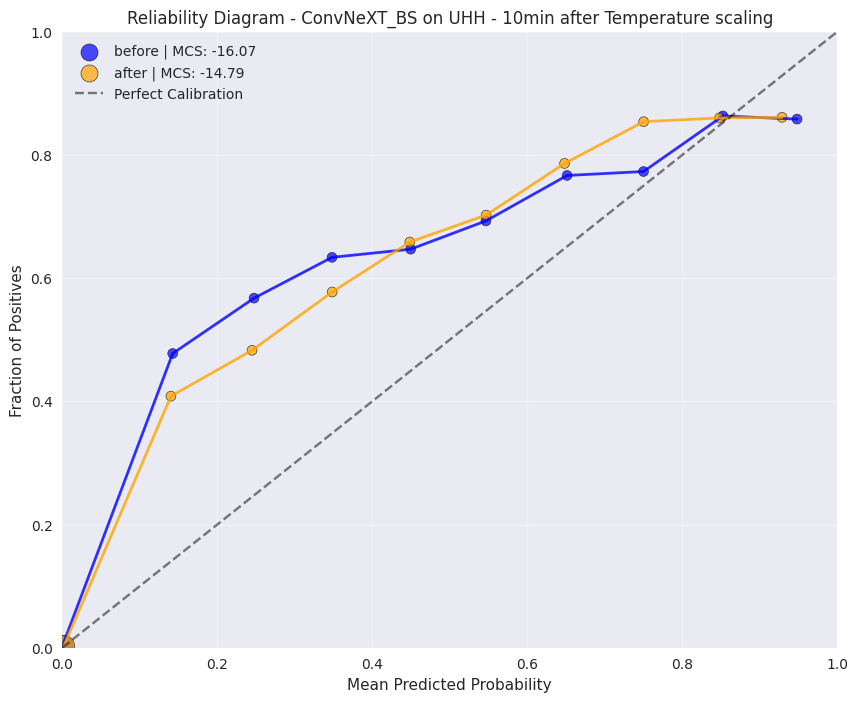

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Temperature scaling",
    )

### Platt scaling

In [ ]:
from uncertainbird.utils.temperature_scaling import fit_per_class_platt_scaling


for ds in valid_keys:

    # compute global temperature value based on POW
    slopes, biases = fit_per_class_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal slopes: {slopes}, biases: {biases} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slopes, biases, model= model
    )
    print('Before platt scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal slope: 0.742, bias: 0.056 for HSN
Before platt scaling:


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1182)
ECE Top-3: tensor(0.1179)
ECE Top-5: tensor(0.0856)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0230)
Miscalibration Score (MCS): tensor(-0.1182)
ECE Under-confidence: tensor(0.1182)
ECE Over-confidence: tensor(3.4392e-05)
After platt scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0043)
F1 Score: tensor(0.0070)
AUROC: tensor(0.0454)
ECE: tensor(0.0018)
ECE Weighted: tensor(0.1152)
ECE Top-3: tensor(0.1152)
ECE Top-5: tensor(0.0827)
ECE Top-10: tensor(0.0451)
ECE Top-21: tensor(0.0228)
Miscalibration Score (MCS): tensor(-0.1151)
ECE Under-confidence: tensor(0.1152)
ECE Over-confidence: tensor(5.1300e-05)
Optimal slope: 1.077, bias: 2.764 for NBP
Before platt scaling:
Accuracy: tensor(0.9965)
cmAP: tensor(0.6088)
Precision: tensor(0.0730)
Recall:

KeyboardInterrupt: 

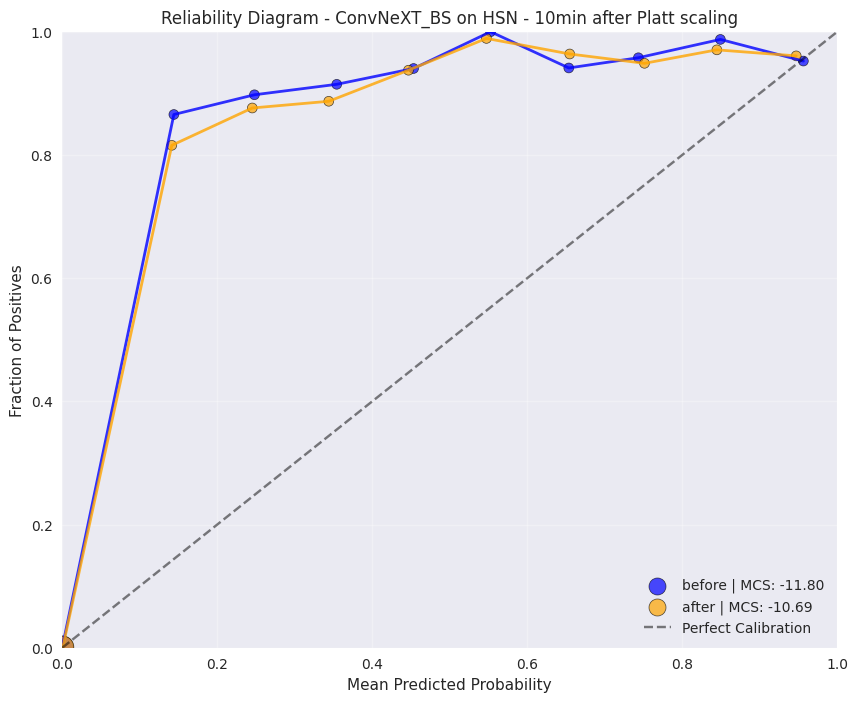

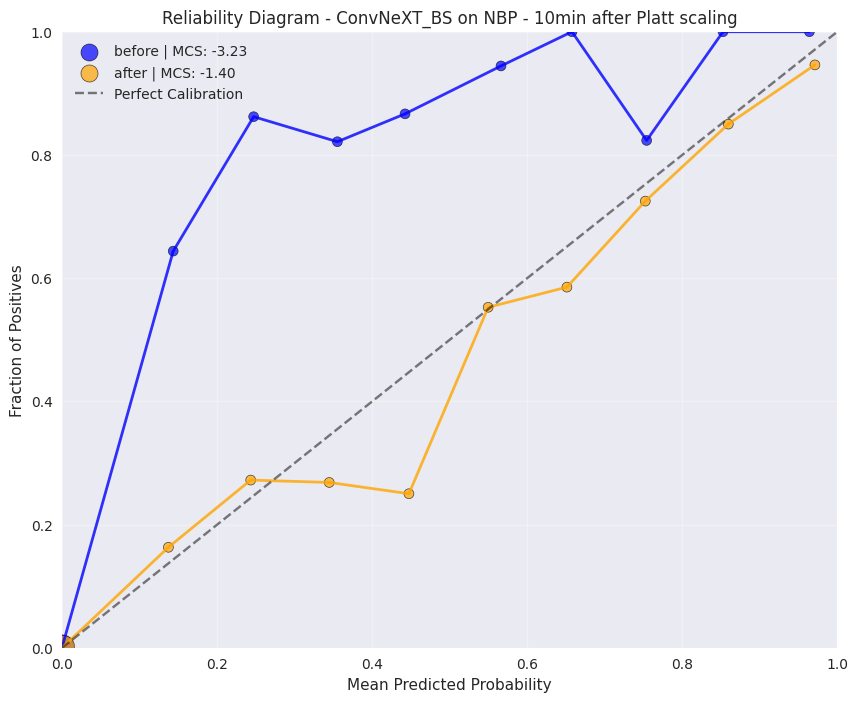

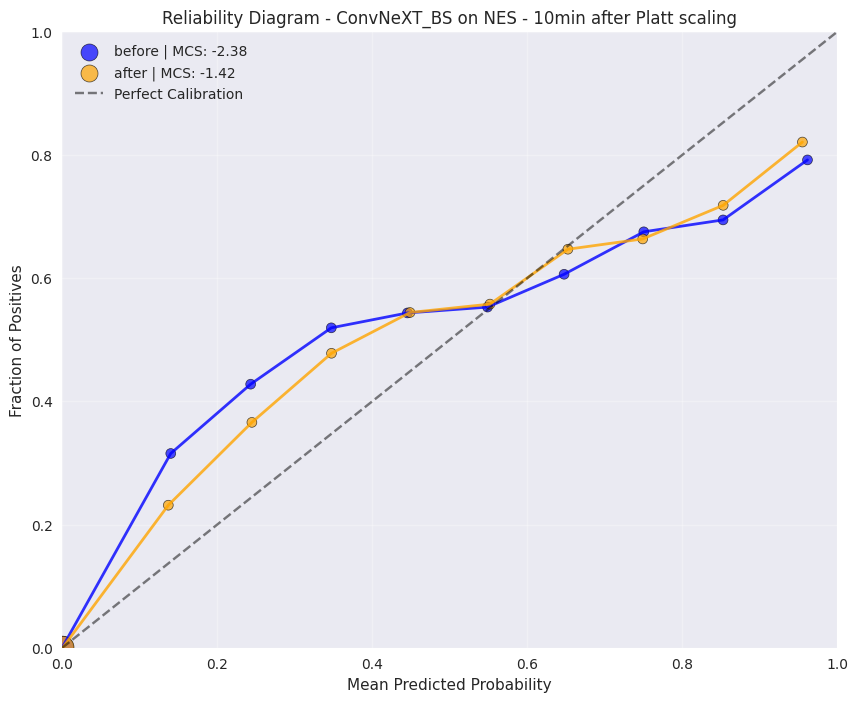

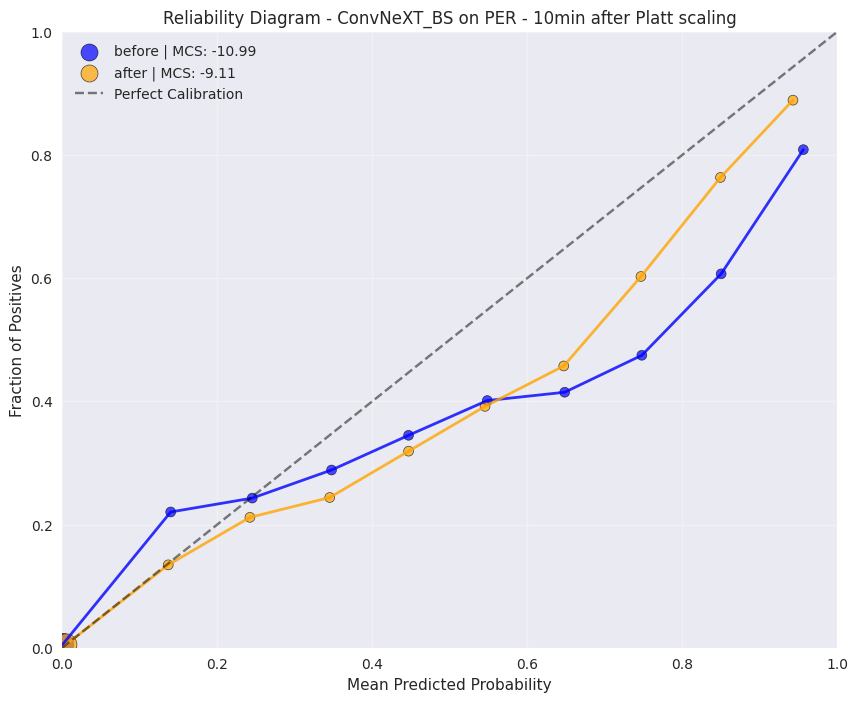

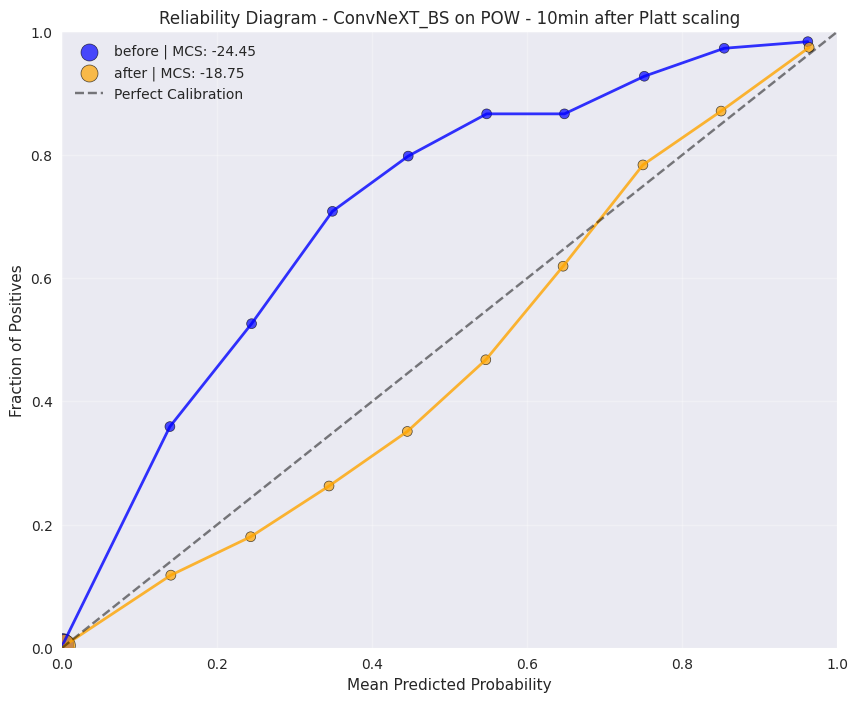

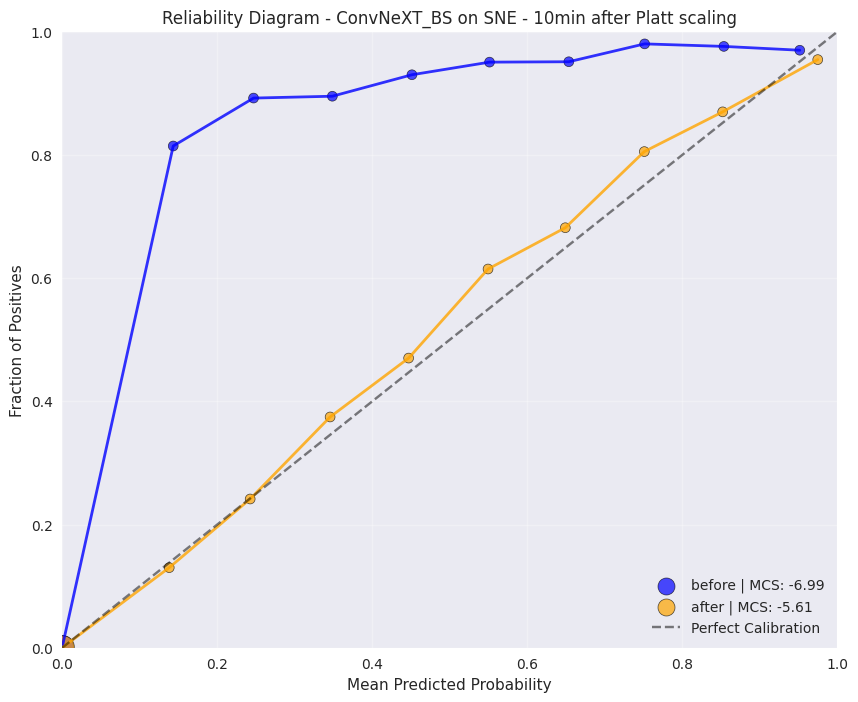

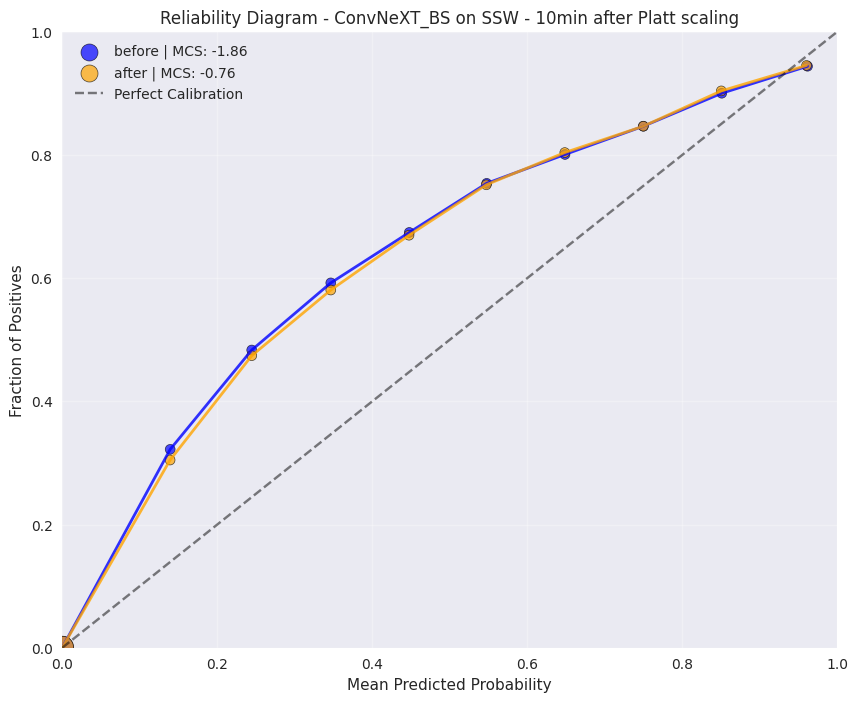

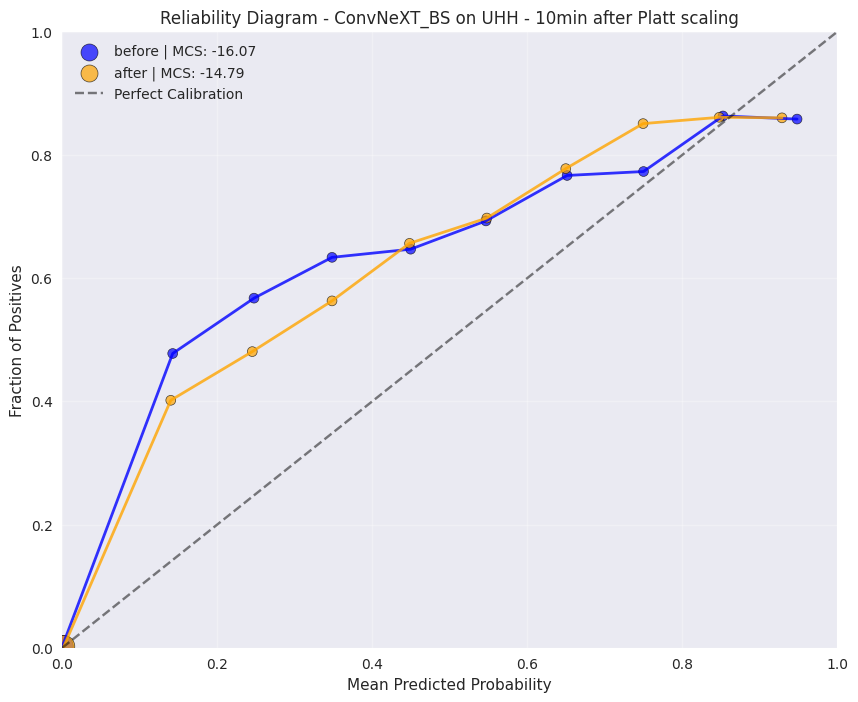

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Platt scaling",
    )

## Parameters per class

### Temperature scaling

In [36]:
from uncertainbird.utils.temperature_scaling import fit_per_class_temperatures


for ds in valid_keys:

    print(f"Fit temperatures per class for {ds}")
    # compute global temperature value based on POW
    temperatures = fit_per_class_temperatures(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )


    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperatures, model= model
    )
    print('Before temperature scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Fit temperatures per class for HSN
Before temperature scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1182)
ECE Top-3: tensor(0.1179)
ECE Top-5: tensor(0.0856)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0230)
Miscalibration Score (MCS): tensor(-0.1182)
ECE Under-confidence: tensor(0.1182)
ECE Over-confidence: tensor(3.4392e-05)
After temperature scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0007)
ECE Weighted: tensor(0.0672)
ECE Top-3: tensor(0.0707)
ECE Top-5: tensor(0.0513)
ECE Top-10: tensor(0.0279)
ECE Top-21: tensor(0.0136)
Miscalibration Score (MCS): tensor(-0.0371)
ECE Under-confidence: tensor(0.0521)
ECE Over-confidence: tensor(0.0150)
Fit temperatures per class for NBP
Before temperature scaling:
Accuracy: tenso

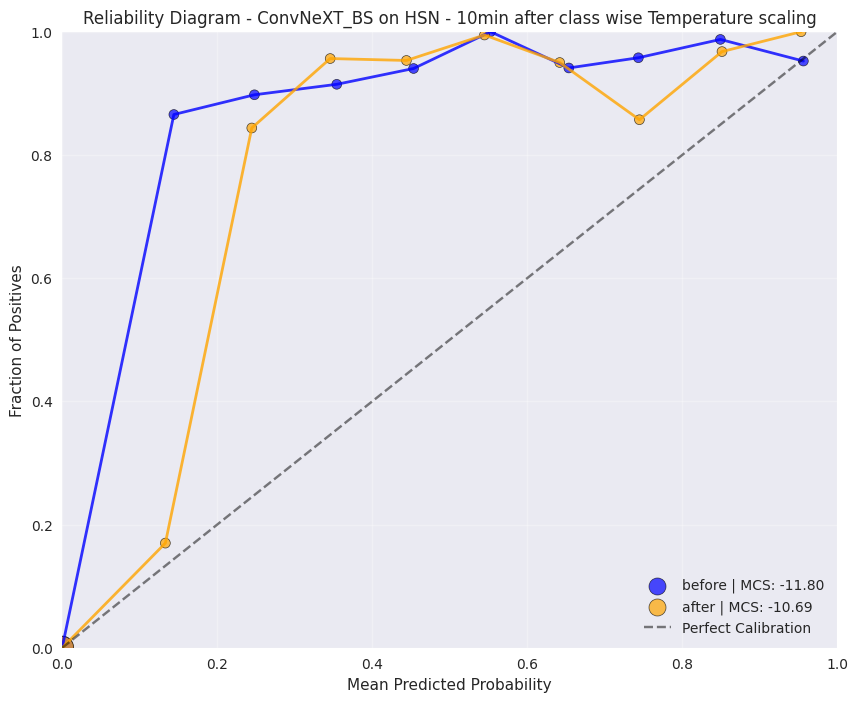

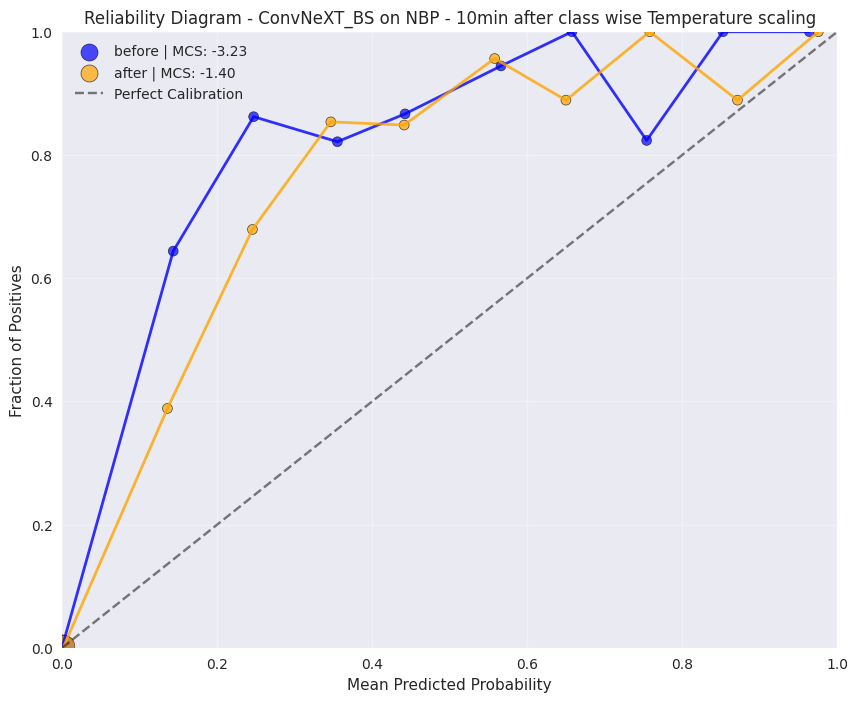

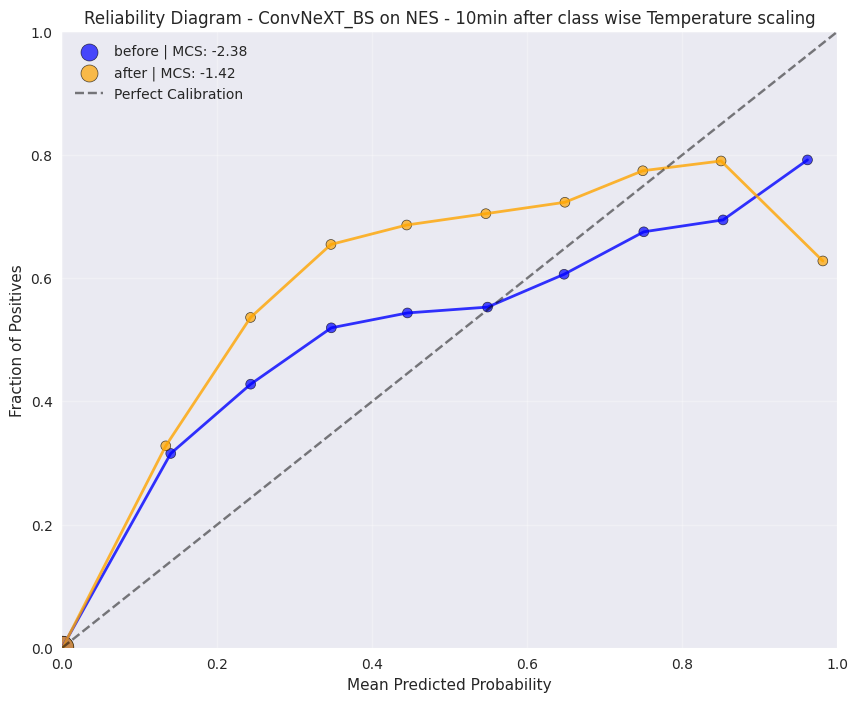

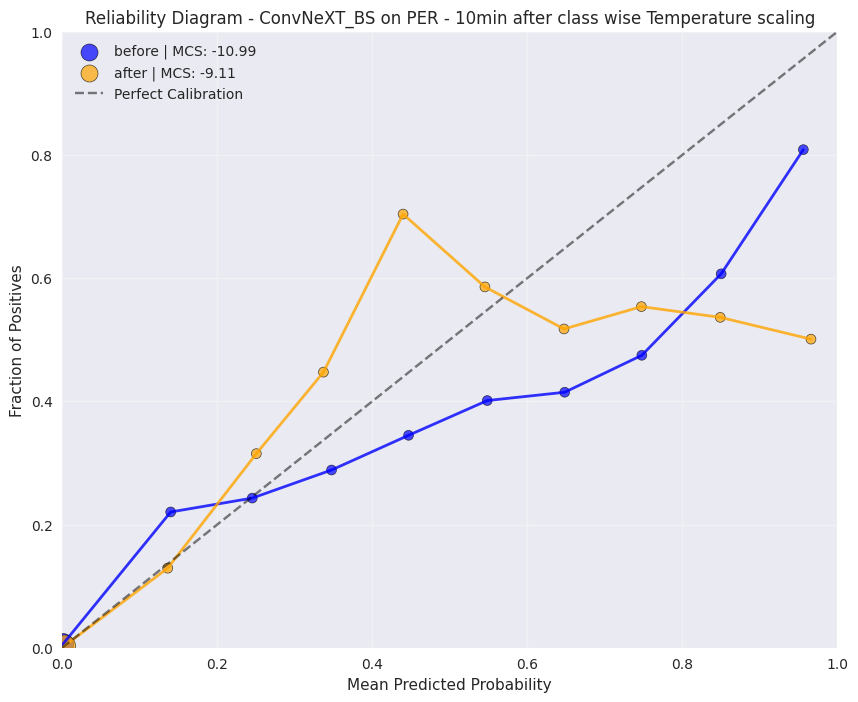

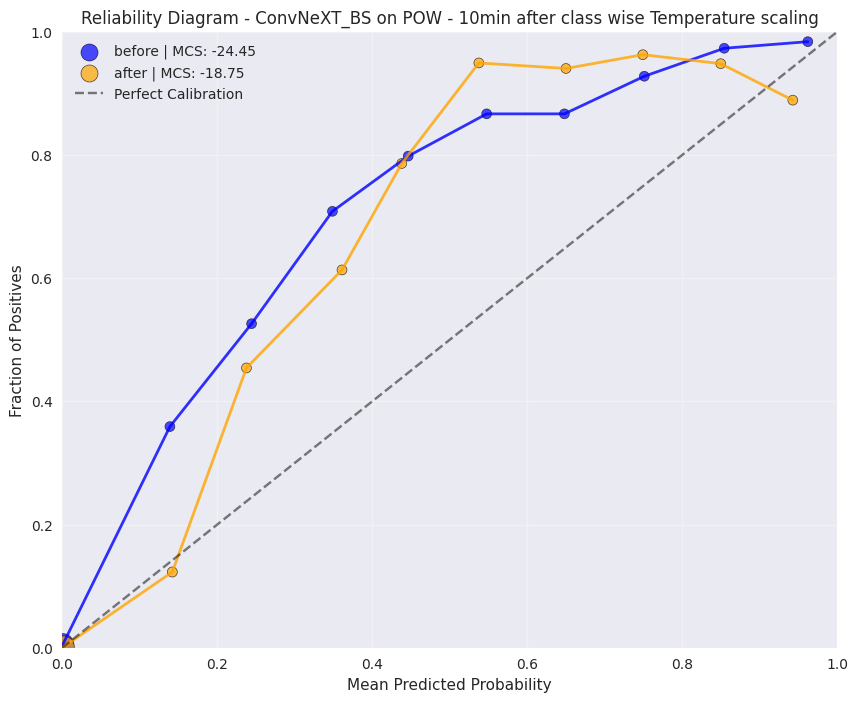

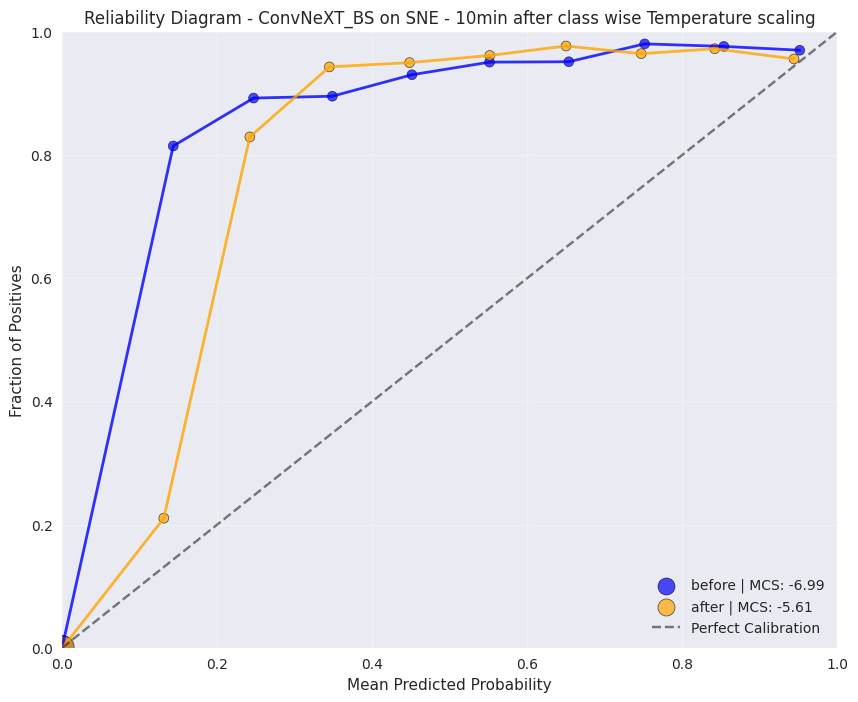

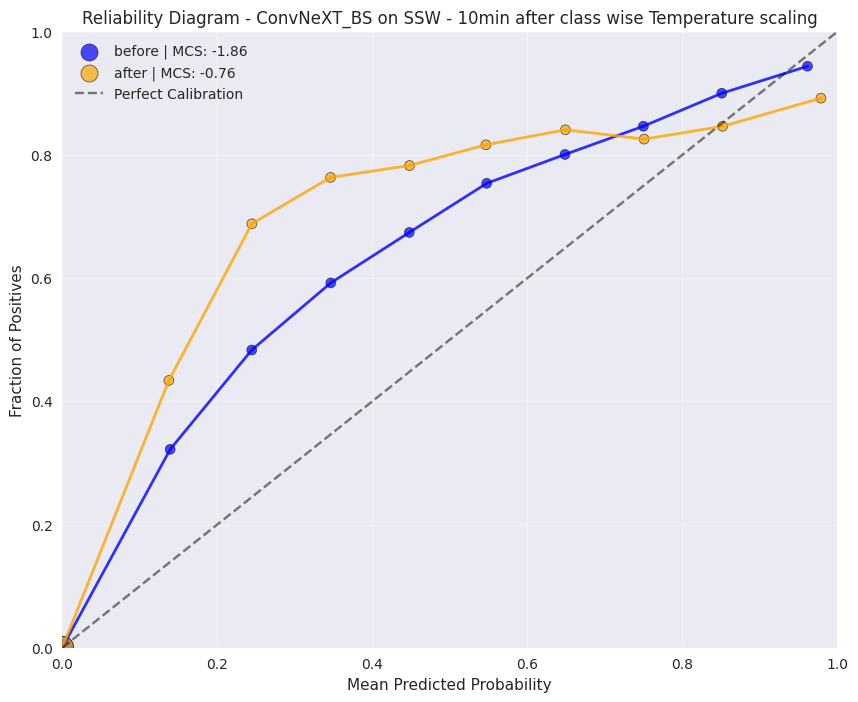

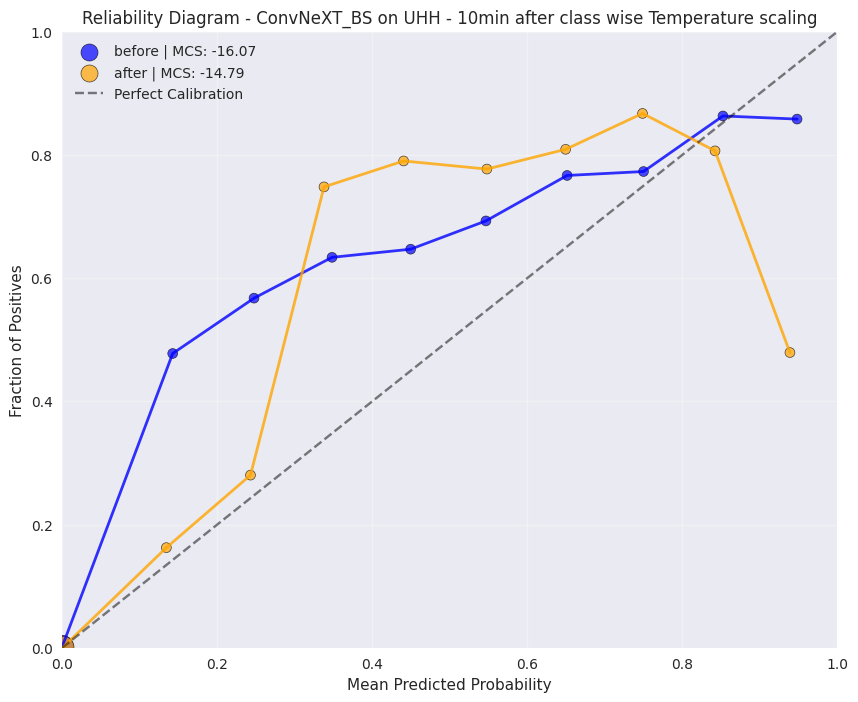

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Temperature scaling",
    )

### Platt scaling

In [ ]:
for ds in valid_keys:

    # compute global temperature value based on POW
    slope, bias = fit_global_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal slope: {slope:.3f}, bias: {bias:.3f} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slope, bias, model= model
    )
    print('Before platt scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal slope: 0.742, bias: 0.056 for HSN
Before platt scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1182)
ECE Top-3: tensor(0.1179)
ECE Top-5: tensor(0.0856)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0230)
Miscalibration Score (MCS): tensor(-0.1182)
ECE Under-confidence: tensor(0.1182)
ECE Over-confidence: tensor(3.4392e-05)
After platt scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.4871)
Precision: tensor(0.0299)
Recall: tensor(0.0043)
F1 Score: tensor(0.0070)
AUROC: tensor(0.0454)
ECE: tensor(0.0018)
ECE Weighted: tensor(0.1152)
ECE Top-3: tensor(0.1152)
ECE Top-5: tensor(0.0827)
ECE Top-10: tensor(0.0451)
ECE Top-21: tensor(0.0228)
Miscalibration Score (MCS): tensor(-0.1151)
ECE Under-confidence: tensor(0.1152)
ECE Over-confidence: tensor(5.1300e-05)
Optimal slope: 1.077, bias: 2.764 for NBP
Before platt scaling:
Accuracy: tenso

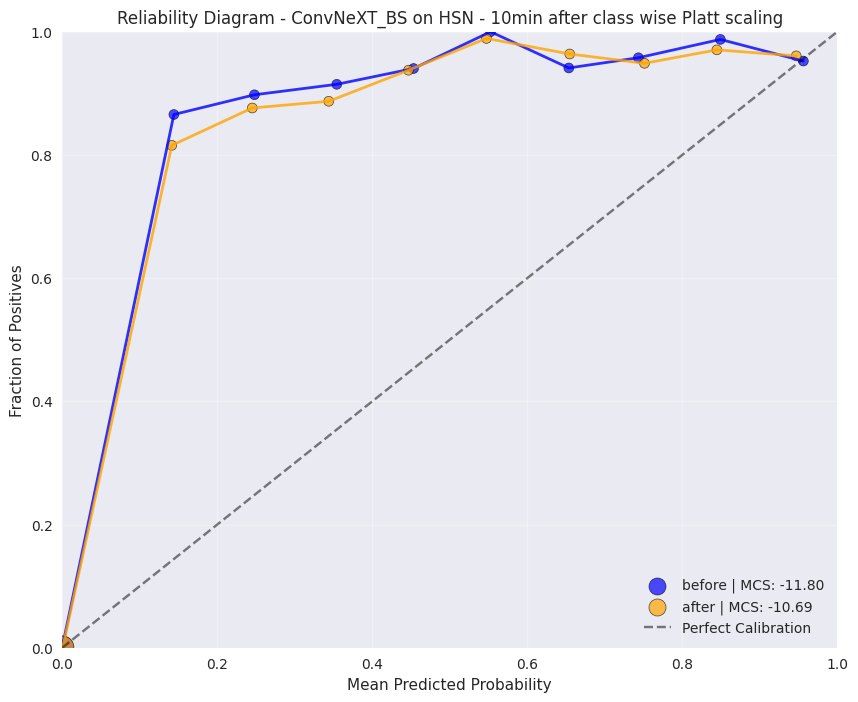

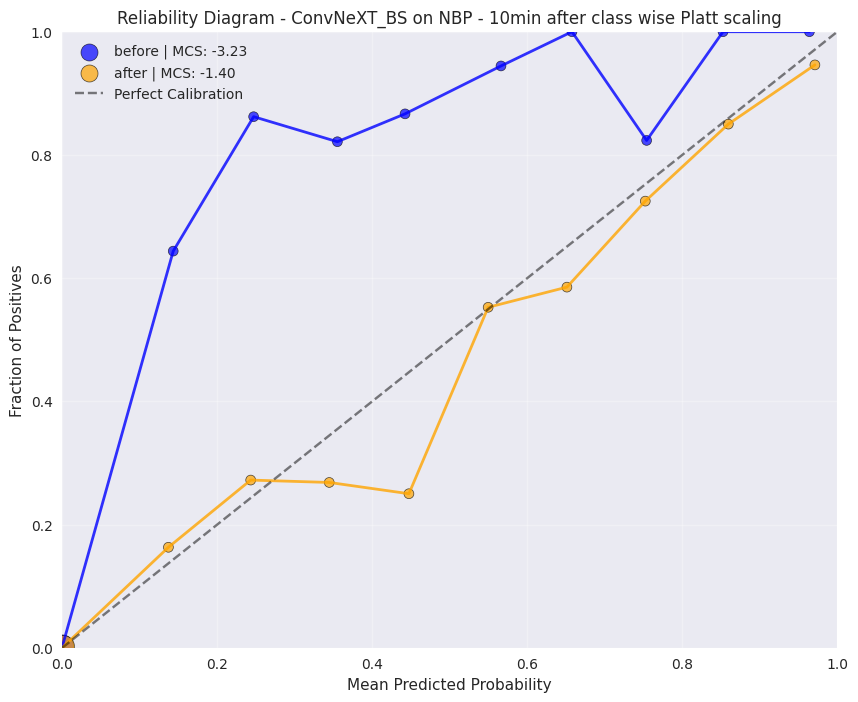

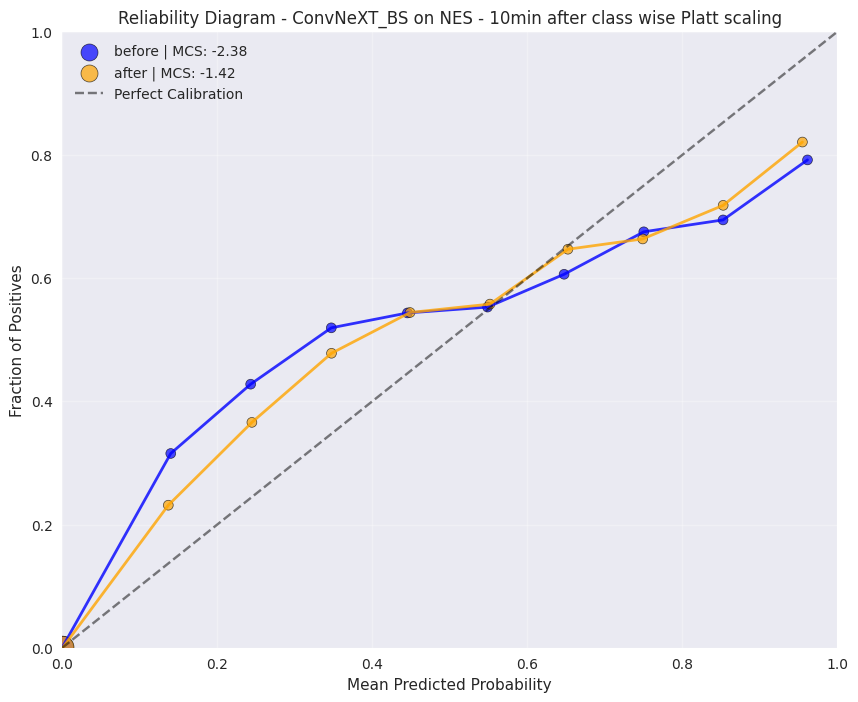

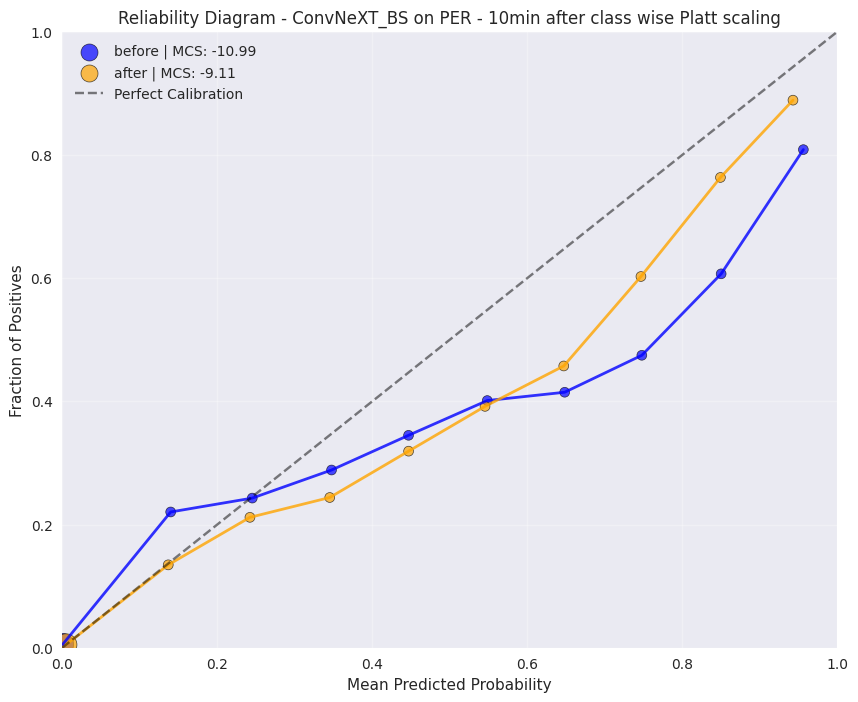

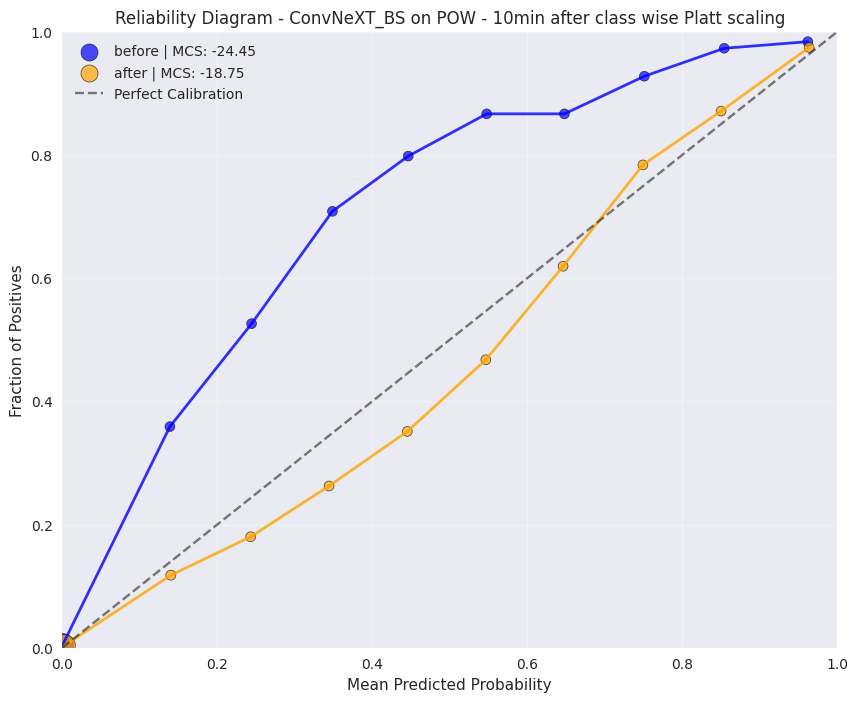

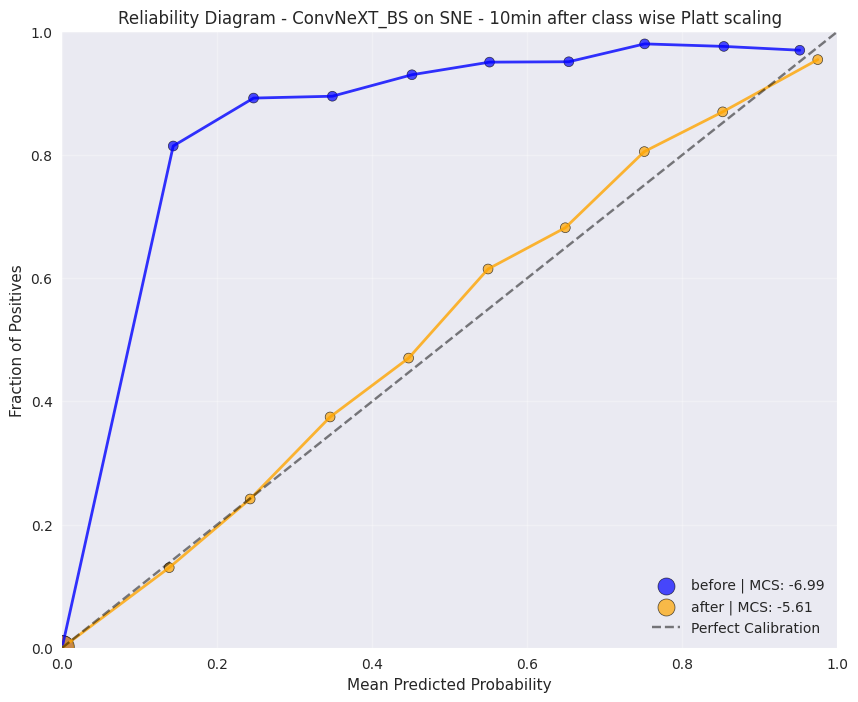

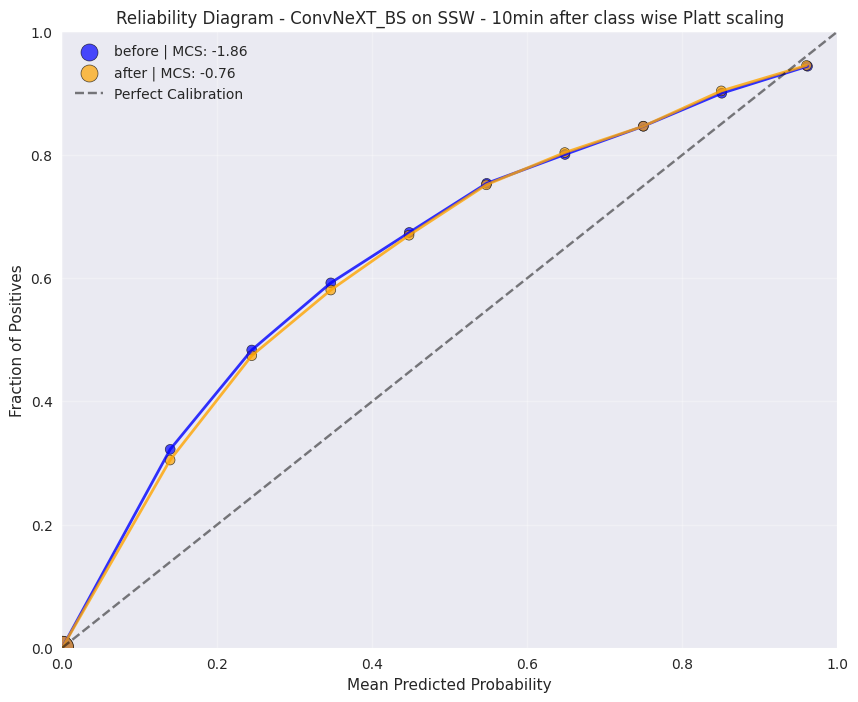

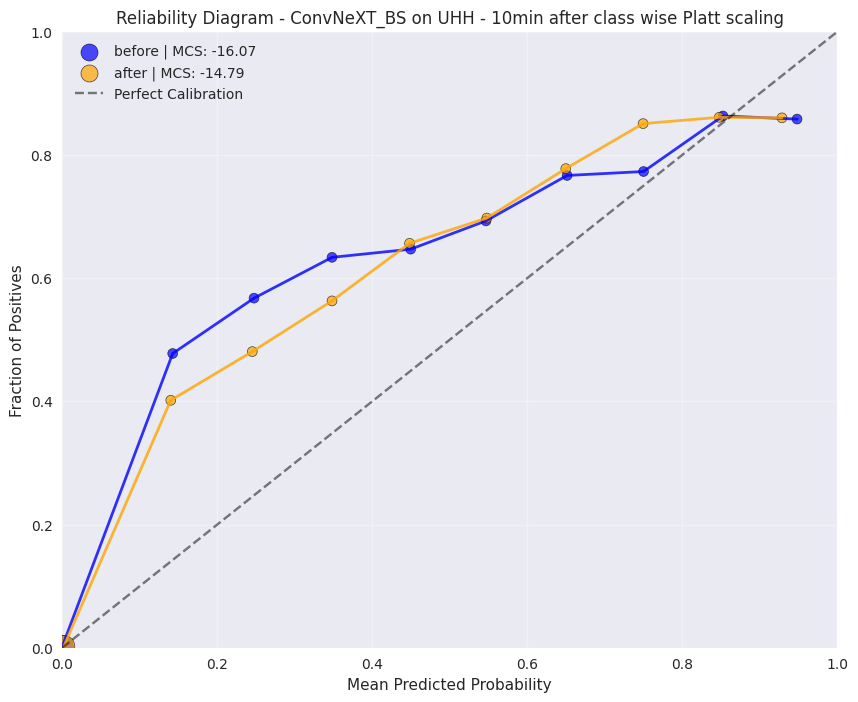

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Platt scaling",
    )